In [1]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.optimize
import itertools
import math

import hoomd
import gsd.hoomd
import coxeter

import freud

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
traj = gsd.hoomd.open('./DATA/trajectory.gsd', 'rb')
traj[-1].log

{'Simulation/timestep': array([160000]),
 'Simulation/walltime': array([63.832509]),
 'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.02587232]),
 'md/compute/ThermodynamicQuantities/pressure': array([17.35354794]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([20.37609408,  1.0417241 ,  1.97365269, 15.93322251,  1.97830926,
        15.75132724]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([195.42867642]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([103.23355265]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([92.19512376]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([47.25739485]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([381.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([189.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([192.]),
 'md/compute/ThermodynamicQuantities/n

In [3]:
traj = gsd.hoomd.open('./DATA/trajectory.gsd', 'rb')

timestep = []
walltime = []
kT= []
pressure = []
pe = []
ke = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    kT.append(frame.log['md/compute/ThermodynamicQuantities/kinetic_temperature'][0])
    pressure.append(frame.log['md/compute/ThermodynamicQuantities/pressure'][0])
    pe.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    
kT = np.asarray(kT)
pressure = np.asarray(pressure)
pe = np.asarray(pe)

In [4]:
frame = traj[-1]
verts = frame.particles.type_shapes[0]['vertices']
particle = coxeter.shapes.ConvexPolyhedron(verts)

num = particle.volume*traj[0].particles.N

phi_arr = []

for frame in traj:

    phi = num/np.prod(frame.configuration.box[:3])
    phi_arr.append(phi)
    
phi_arr = np.asarray(phi_arr)

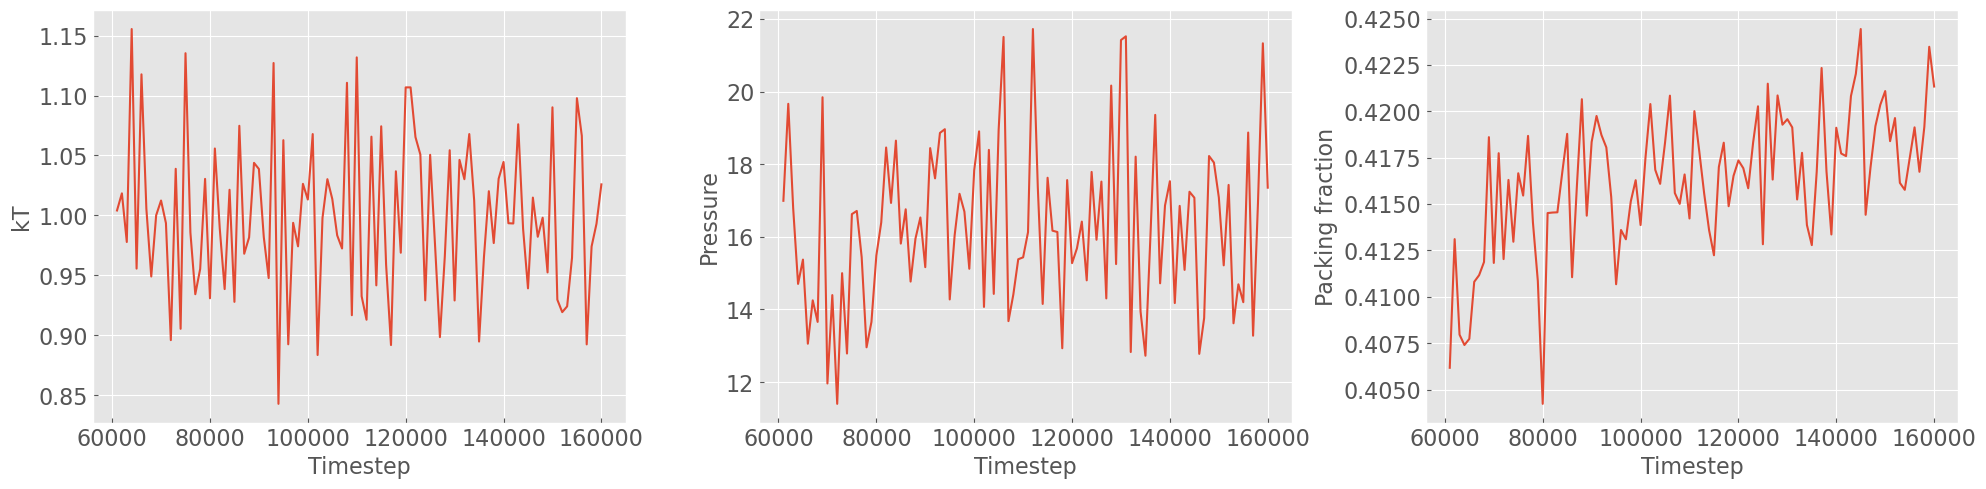

In [5]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

ax[0].plot(timestep, kT)
ax[0].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[0].set_xlabel('Timestep', size=16)
ax[0].set_ylabel('kT', size=16)

ax[1].plot(timestep, pressure)
ax[1].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[1].set_xlabel('Timestep', size=16)
ax[1].set_ylabel('Pressure', size=16)

ax[2].plot(timestep, phi_arr)
ax[2].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[2].set_xlabel('Timestep', size=16)
ax[2].set_ylabel('Packing fraction', size=16)

fig.tight_layout()
plt.show()

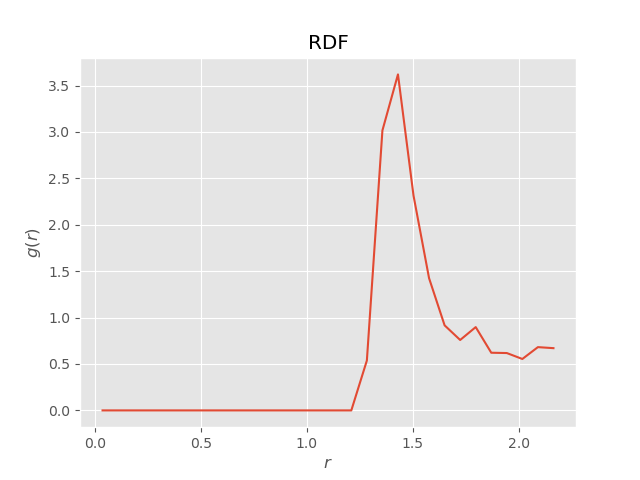

<Figure size 640x480 with 0 Axes>

In [6]:
rdf = freud.density.RDF(bins=30, r_max=2.2)

rdf.compute(system=frame)

In [7]:
qc = freud.order.Steinhardt(l=6, average=True)

qc_arr = []

for frame in traj:
    
    box = frame.configuration.box
    points = frame.particles.position
    
    system = freud.AABBQuery(box, points)
    args = {"num_neighbors": 6, "exclude_ii": True}
    nlist = system.query(points, args).toNeighborList()
    
    qc.compute(system, neighbors=nlist)
    qc_arr.append(qc.order)
    
qc_arr = np.asarray(qc_arr)

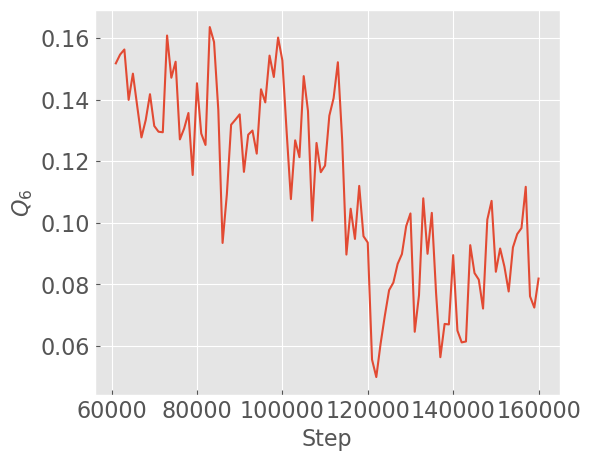

In [8]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(timestep, qc_arr)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Step', size=16)
ax.set_ylabel('$Q_6$', size=16)

plt.show()

In [9]:
nop_arr = []

for frame in traj:
    
    nop = freud.order.Nematic([0,0,1])
    nop_val = nop.compute(frame.particles.orientation)
    nop_arr.append(nop_val.order)
    
nop_arr = np.asarray(nop_arr)

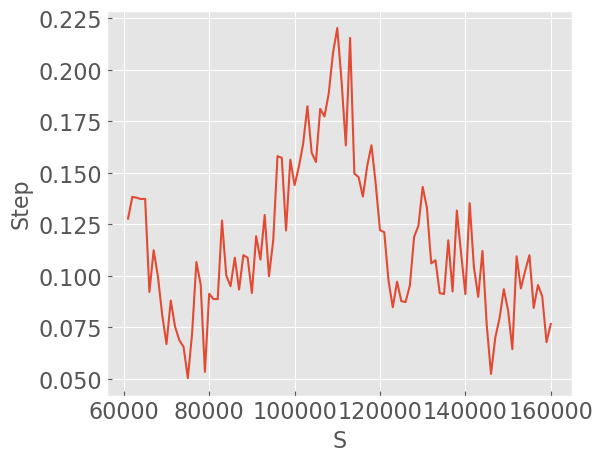

In [10]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(timestep, nop_arr)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('S', size=16)
ax.set_ylabel('Step', size=16)

plt.show()

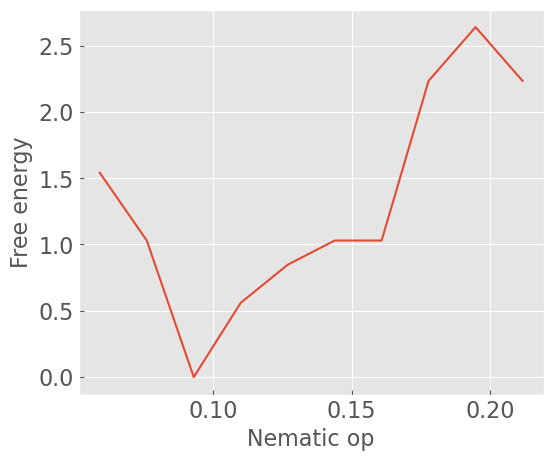

In [11]:
hist = np.histogram(nop_arr[:], bins=10)
prob = hist[0].T/np.sum(hist[0].T)
freeE = -np.log(prob+1e-11)
mids = 0.5*(hist[1][1:]+hist[1][:-1])

fig, ax = plt.subplots(figsize=(6,5))

ax.plot(mids, freeE-np.min(freeE))

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Nematic op', size=16)
ax.set_ylabel('Free energy', size=16)

plt.show()

In [12]:
import rowan
from mpl_toolkits.mplot3d import Axes3D

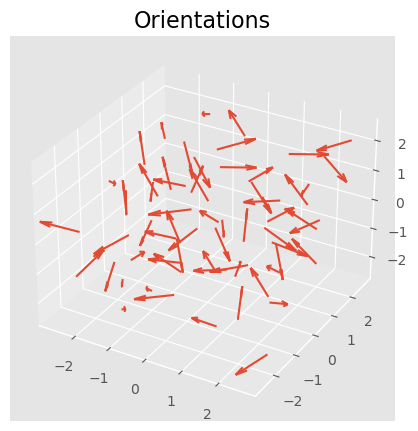

In [13]:
frame = traj[-1]
points = frame.particles.position[:100]
orientations = frame.particles.orientation[:100]

# To show orientations, we use arrows rotated by the quaternions.
arrowheads = rowan.rotate(orientations, [0,0,1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.quiver3D(points[:,0],
            points[:,1],
            points[:,2],
            arrowheads[:,0],
            arrowheads[:,1],
            arrowheads[:,2]
)
ax.set_title("Orientations", fontsize=16);

#### Diffraction pattern

In [14]:
dp = freud.diffraction.DiffractionPattern(grid_size=1024, output_size=1024)

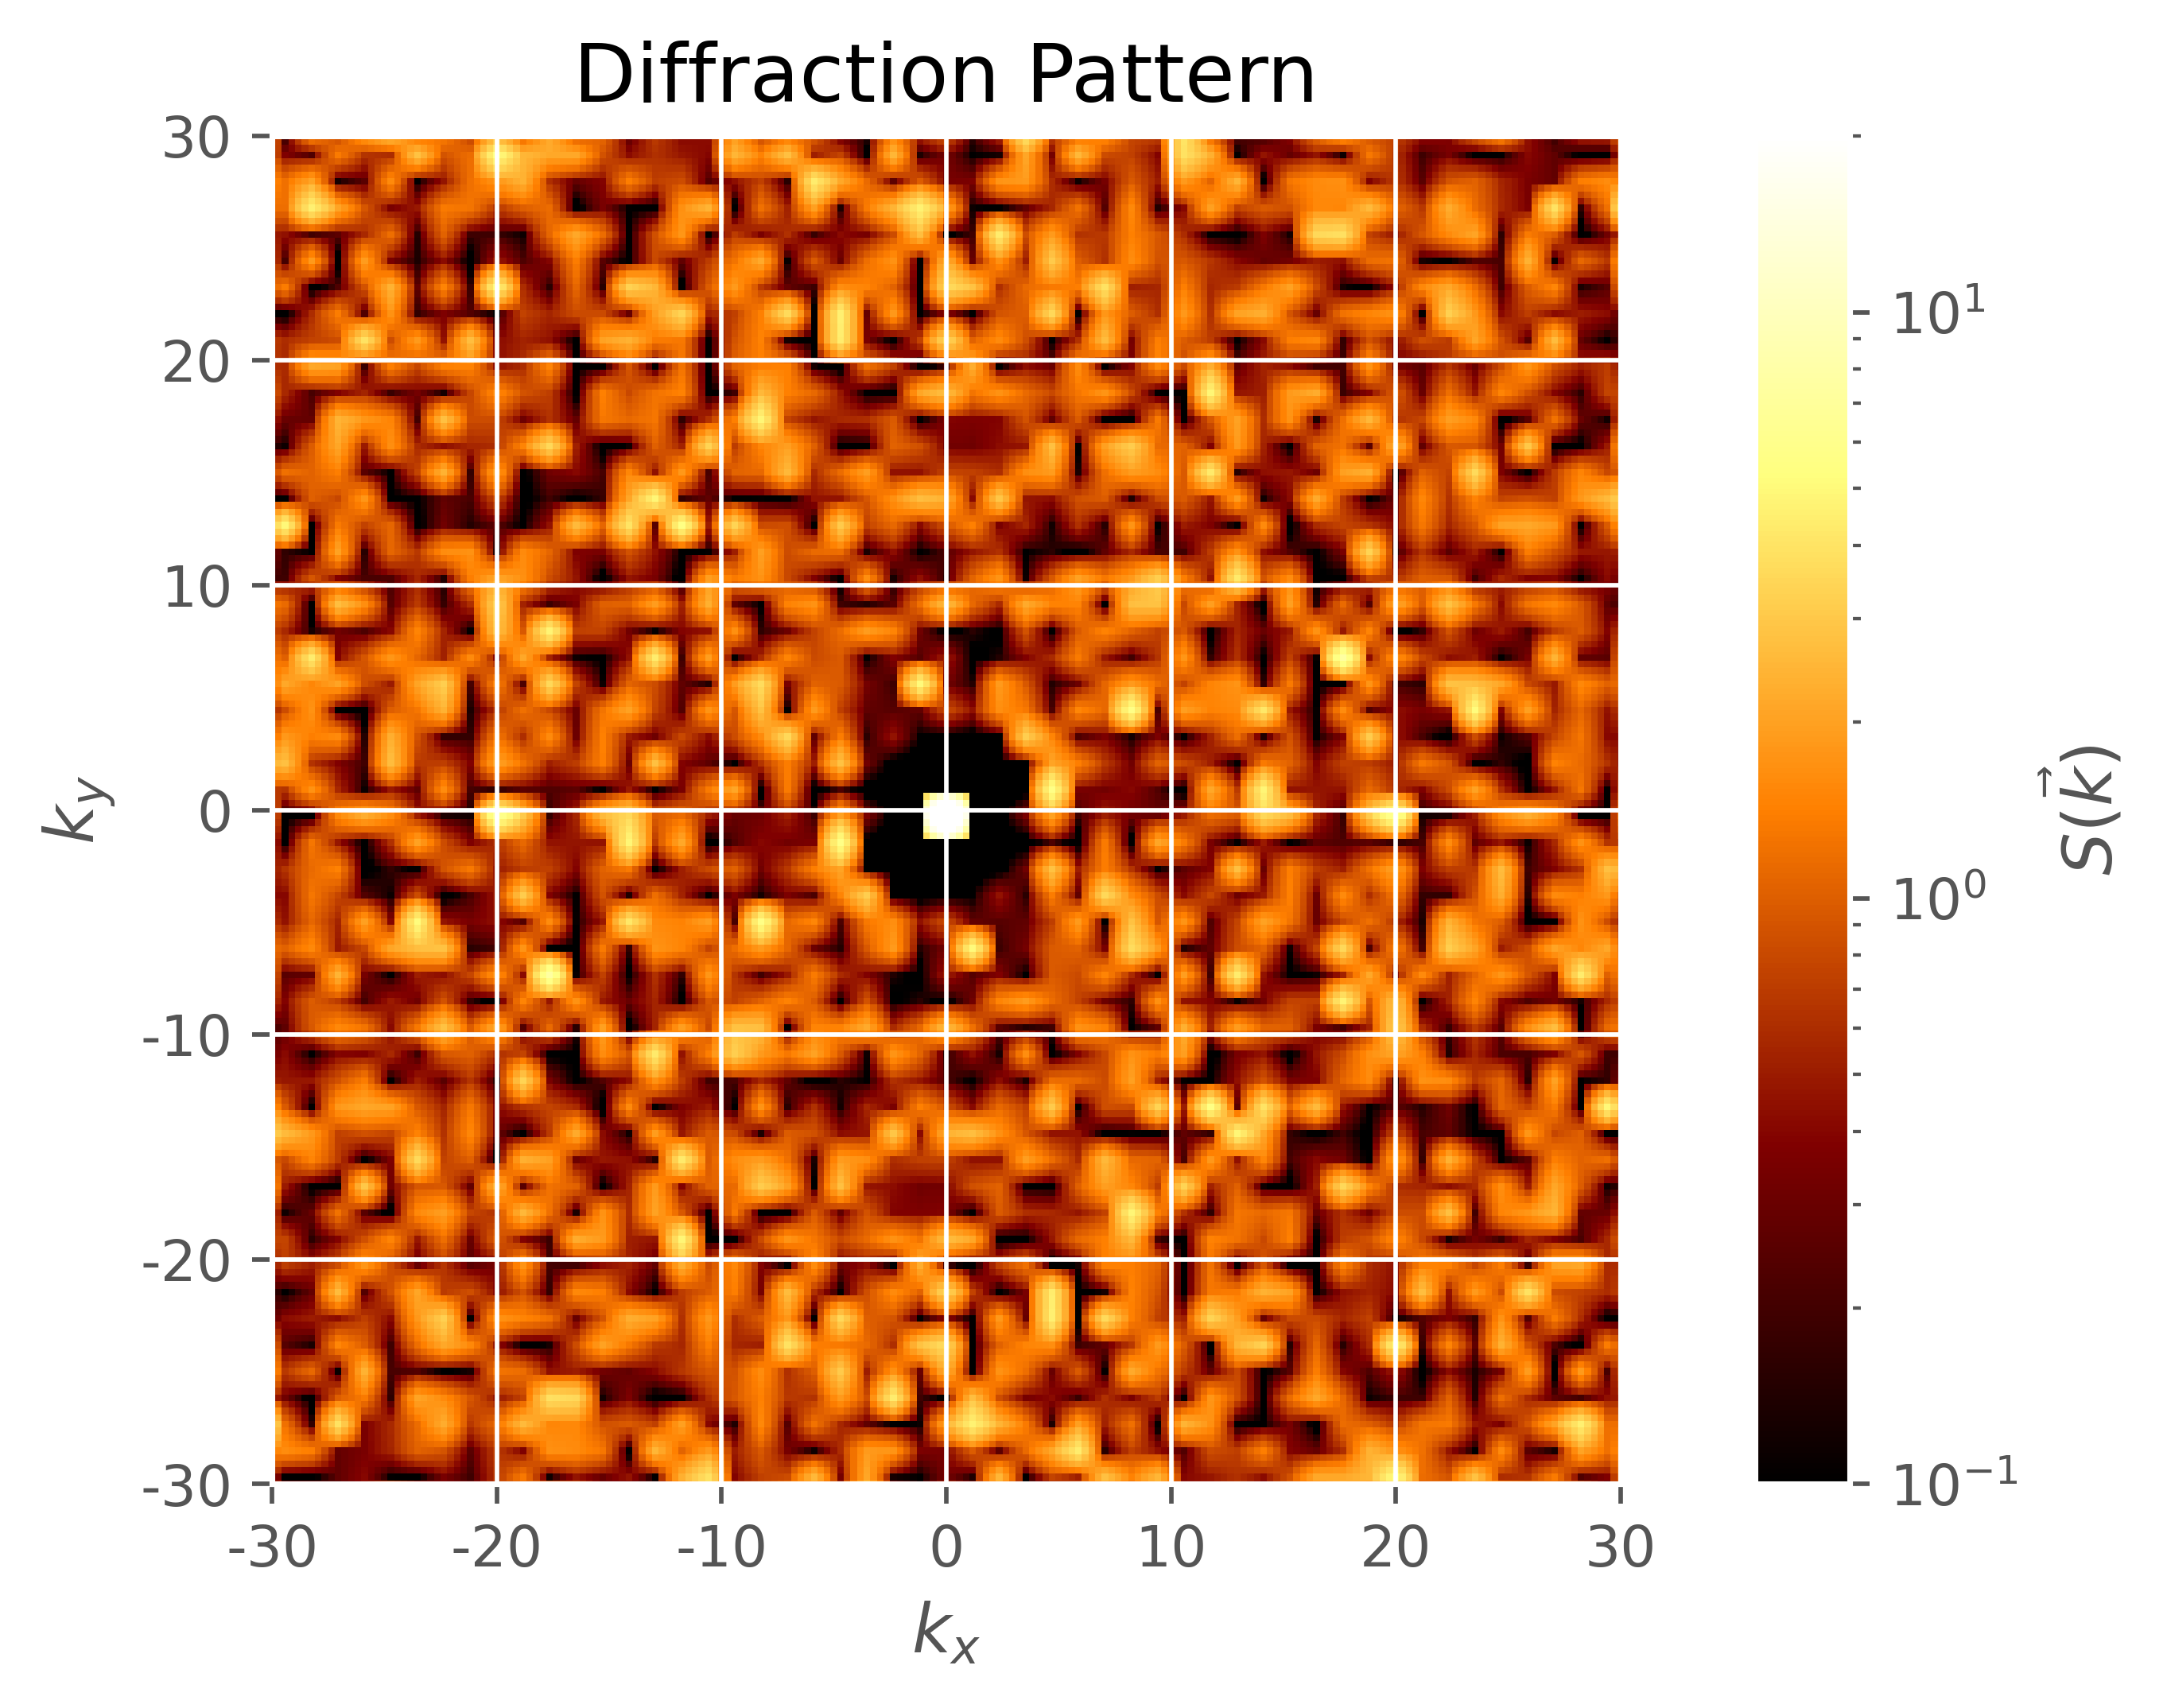

In [15]:
frame=traj[-1]

fig, ax = plt.subplots(figsize=(5,5), dpi=512)
dp.compute((frame.configuration.box,
            frame.particles.position),
            view_orientation=[1,0,0,0])
dp.plot(ax, vmin=0.1, vmax=20)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
plt.show()